In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Data.zip"


unzip:  cannot find or open /content/drive/My Drive/Data.zip, /content/drive/My Drive/Data.zip.zip or /content/drive/My Drive/Data.zip.ZIP.


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools



In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG
benign_train = np.array(Dataset_loader('/content/Data/Train/benign',224))
malign_train = np.array(Dataset_loader('/content/Data/Train/Malignant',224))
benign_test = np.array(Dataset_loader('/content/Data/validation/benign',224))
malign_test = np.array(Dataset_loader('/content/Data/validation/Malignant',224))


FileNotFoundError: ignored

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
trace = go.Bar(x = (len(benign_train), len(malign_train)), y = ['benign', 'malignant'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [ ]:
#DATA LABELING
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)
#DATA SUFFLING
# If the order of data within each epoch is the same, then the model may use this 
#as a way of reducing the training error, which is a sort of overfitting.
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

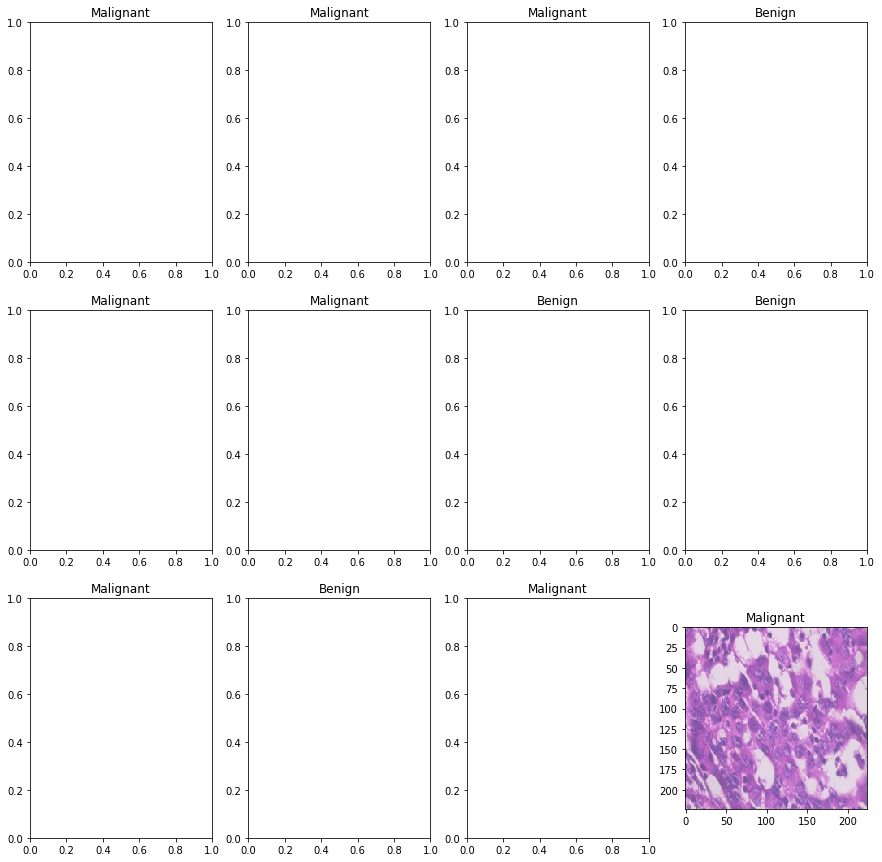

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
X_train, Y_train,
test_size=0.2,
random_state=11
)
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
       ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
print('x_train shape:',x_train.shape)
print('Number of images in x_train:', x_train.shape[0])
print('Number of images in x_test:', X_test.shape[0])
print('Number of images in x_val:', x_val.shape[0])


x_train shape: (1304, 224, 224, 3)
Number of images in x_train: 1304
Number of images in x_test: 362
Number of images in x_val: 327


In [ ]:
BATCH_SIZE = 16
train_generator = ImageDataGenerator(
  zoom_range=[0.5,1.0], # set range for random zoom
  rotation_range = 90,
  horizontal_flip=True, # randomly flip images
  vertical_flip=True, # randomly flip images
)

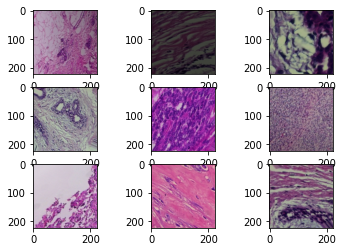

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import img_to_array

# prepare iterator
it = train_generator.flow(X_train, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()


In [ ]:
from keras.applications.resnet50 import ResNet50

def build_model(backbone, lr=1e-3):
      model = Sequential()
      model.add(backbone)
      model.add(layers.GlobalAveragePooling2D())
      model.add(layers.Dropout(0.5))
      model.add(layers.BatchNormalization())
      model.add(layers.Dense(2, activation='softmax'))
      model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(lr=lr),
      metrics=['accuracy']
)
      return model

      

resnet = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3)
)


model = build_model(resnet ,lr = 1e-4)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



94658560/94653016 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [ ]:
import tensorflow.keras.backend as K
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
filepath="weights.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

history = model.fit_generator(
      train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
      steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
      epochs=20,
      validation_data=(x_val, y_val),
      callbacks=[learn_control, checkpoint]
)

Epoch 1/20
82/81 [==============================] - 93s 1s/step - loss: 0.4529 - accuracy: 0.8267 - val_loss: 0.3069 - val_accuracy: 0.8838
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning:

Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning:

Can save best model only with val_acc available, skipping.



82/81 [==============================] - 66s 807ms/step - loss: 0.2492 - accuracy: 0.9133 - val_loss: 0.0983 - val_accuracy: 0.9572
Epoch 3/20
82/81 [==============================] - 66s 809ms/step - loss: 0.2591 - accuracy: 0.9011 - val_loss: 1.0530 - val_accuracy: 0.6544
Epoch 4/20
82/81 [==============================] - 66s 805ms/step - loss: 0.2070 - accuracy: 0.9233 - val_loss: 0.3490 - val_accuracy: 0.8410
Epoch 5/20
82/81 [==============================] - 66s 807ms/step - loss: 0.1728 - accuracy: 0.9363 - val_loss: 0.4625 - val_accuracy: 0.7829
Epoch 6/20
82/81 [==============================] - 66s 808ms/step - loss: 0.1508 - accuracy: 0.9494 - val_loss: 0.5565 - val_accuracy: 0.8043
Epoch 7/20
82/81 [==============================] - 66s 808ms/step - loss: 0.1164 - accuracy: 0.9563 - val_loss: 0.1872 - val_accuracy: 0.9358
Epoch 8/20
82/81 [==============================] - 66s 809ms/step - loss: 0.1456 - accuracy: 0.9433 - val_loss: 0.2461 - val_accuracy: 0.9266
Epoch 9/20

In [ ]:
model.save('weights.hdf5')

In [ ]:
# evaluate the model
score = model.evaluate(x_val, y_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 97.55%


In [ ]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_val, y_val, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
3/3 [==============================] - 2s 535ms/step - loss: 0.1698 - accuracy: 0.9279
test loss, test acc: [0.16975770890712738, 0.9278996586799622]


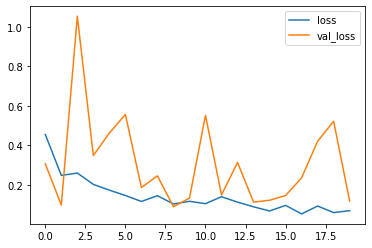

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

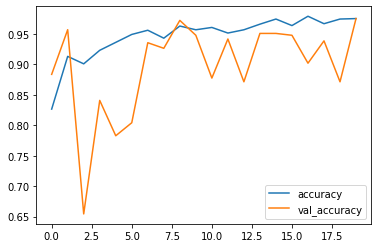

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
tta_steps = 10

predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


Confusion matrix, without normalization
[[180   6]
 [  1 175]]


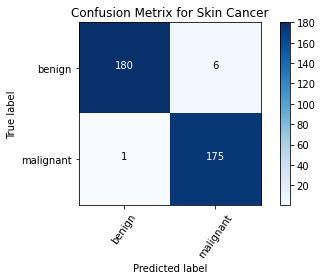

In [ ]:
  from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[285   1]
 [  0 146]]


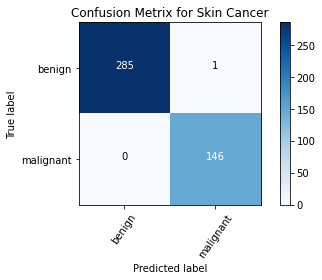

In [ ]:

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       286\n           1       0.99      1.00      1.00       146\n\n    accuracy                           1.00       432\n   macro avg       1.00      1.00      1.00       432\nweighted avg       1.00      1.00      1.00       432\n'

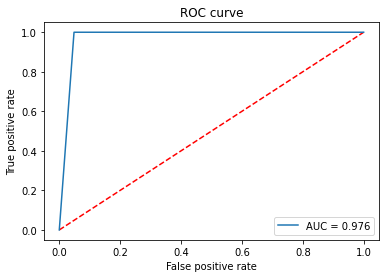

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
pip install miscnn


     |████████████████████████████████| 122kB 3.1MB/s 
     |████████████████████████████████| 13.0MB 239kB/s 
     |████████████████████████████████| 2.1MB 26.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 3.3MB 27.1MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.20.1-cp36-none-any.whl size=70315 sha256=cbc689e8326921f204925b4b61583f5f8ad8951bd37a484421ed2da1bc722a09
  Stored in directory: /root/.cache/pip/wheels/da/6d/f4/6f4c4fcd88115a2e9963bd144b75e78d8ecc72e94e164d8b6b
Successfully built batchgenerators
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found exist

In [ ]:
import miscnn

# Create a Data I/O interface for kidney tumor CT scans in NIfTI format
from miscnn.data_loading.interfaces import NIFTI_interface
interface = NIFTI_interface(pattern="case_000[0-9]*", channels=1, classes=3)



In [ ]:
# Initialize data path and create the Data I/O instance
data_path = "/content/drive/My Drive"
data_io = miscnn.Data_IO(interface, data_path)

In [ ]:
# Create and configure the Preprocessor class
pp = miscnn.Preprocessor(data_io, batch_size=2, analysis="patchwise-crop",
                         patch_shape=(80,160,160))

In [ ]:
# Create and configure the Data Augmentation class
data_aug = miscnn.Data_Augmentation(cycles=1, scaling=True, rotations=True,
                                    elastic_deform=True, mirror=True,
                                    brightness=True, contrast=True,
                                    gamma=True, gaussian_noise=True)

# Create and configure the Preprocessor class
pp = miscnn.Preprocessor(data_io, data_aug=data_aug, batch_size=2,
                        analysis="patchwise-crop", patch_shape=(80,160,160))

In [ ]:
# Import standard U-Net architecture and Soft Dice
from miscnn.neural_network.architecture.unet.standard import Architecture
from miscnn.neural_network.metrics import dice_soft
unet_standard = Architecture()

# Create a deep learning neural network model with a standard U-Net architecture
model = miscnn.Neural_Network(preprocessor=pp, architecture=unet_standard,
                              loss=dice_soft)